In [1]:
from google.colab import files
import os
files.upload()  # kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"worldmansist15","key":"58a9df1a79834b926c0f4a00861dd558"}'}

In [2]:
!pip install -q kaggle

os.makedirs("/root/.kaggle", exist_ok=True)
if os.path.exists("kaggle.json"):
    os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")



Done!


In [4]:
# Checking
DATA_DIR = "/content/datasciencebowl"
print("Train classes:", len(os.listdir(f"{DATA_DIR}/train")))
print("Test :",  len(os.listdir(f"{DATA_DIR}/test")))

Train classes: 121
Test : 1


# Work with classes

In [5]:
import pandas as pd
from PIL import Image
from collections import Counter

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

In [6]:
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

n_classes = len(classes)

print(f"Number of classes: {n_classes}")
print("First 10 classes:", classes[:10])

Number of classes: 121
First 10 classes: ['acantharia_protist', 'acantharia_protist_big_center', 'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae', 'appendicularian_s_shape', 'appendicularian_slight_curve', 'appendicularian_straight', 'artifacts', 'artifacts_edge']


In [8]:
class_counts = {}

for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    class_counts[cls] = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

df_counts = (
    pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
    .sort_values("num_images", ascending=False)
)

df_counts

,num_images
trichodesmium_puff,1979
chaetognath_other,1934
copepod_cyclopoid_oithona_eggs,1189
protist_other,1172
detritus_other,914
...,...
pteropod_theco_dev_seq,13
hydromedusae_other,12
fish_larvae_deep_body,10
heteropod,10


In [9]:
threshold = 0

df_counts_filtered = df_counts[df_counts["num_images"] > threshold]

print(f"Classes with more than {threshold} images: {len(df_counts_filtered)}")

Classes with more than 0 images: 121


In [11]:
classes_filtered = df_counts_filtered.index.tolist()
n_classes_filtered = len(classes_filtered)

# Sizes

In [12]:
sizes = []

for cls in classes_filtered:
    cls_path = os.path.join(TRAIN_DIR, cls)

    for fname in os.listdir(cls_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(cls_path, fname)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

df_sizes = pd.DataFrame(sizes, columns=["width", "height"])
df_sizes.describe()

,width,height
count,30336.000000,30336.000000
mean,73.507285,66.661821
std,49.162891,43.460964
min,31.000000,21.000000
25%,44.000000,43.000000
50%,56.000000,53.000000
75%,83.000000,72.000000
max,424.000000,428.000000


# PyTorch Dataset

In [13]:
# 2. Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [14]:
from torch.utils.data import Dataset

# 3. Custom dataset
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [15]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 49
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 88


In [16]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

pixel_sum = np.zeros(3)
pixel_sq_sum = np.zeros(3)
pixel_count = 0

for cls in tqdm(classes_filtered):
    cls_dir = os.path.join(TRAIN_DIR, cls)

    for f in os.listdir(cls_dir):
        img = np.array(
            Image.open(os.path.join(cls_dir, f)).convert("RGB"),
            dtype=np.float32
        )

        # shape: H x W x 3
        pixel_sum += img.sum(axis=(0, 1))
        pixel_sq_sum += (img ** 2).sum(axis=(0, 1))
        pixel_count += img.shape[0] * img.shape[1]

# mean / std per channel
global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean ** 2)

print("Global mean:", global_mean)
print("Global std:", global_std)



# global_mean = [mR, mG, mB]
# global_std  = [sR, sG, sB]

100%|██████████| 88/88 [00:17<00:00,  4.93it/s]

Global mean: [241.03449992 241.03449992 241.03449992]
Global std: [40.78570893 40.78570893 40.78570893]


# Transformations and augmentations

In [17]:
from torchvision import transforms

GLOBAL_MEAN = (global_mean / 255.0).tolist()
GLOBAL_STD  = (global_std  / 255.0).tolist()

train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

In [18]:
# 7. Dataset
base_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered
)

labels = [base_dataset.label2idx[label] for label, _ in base_dataset.samples]
indices = list(range(len(base_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


train_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=train_transform
)

val_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=val_transform
)

train_ds = Subset(train_dataset, train_idx)
val_ds   = Subset(val_dataset, val_idx)

In [19]:
from torch.utils.data import DataLoader

# 8. DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Baseline model

In [20]:
# @title
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

model.fc = nn.Linear(
    model.fc.in_features,
    len(classes_filtered)
)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [21]:
# @title
import numpy as np
import torch
from collections import Counter

# ===== GET TRAIN LABELS FROM Subset =====
train_labels = [
    train_ds.dataset.label2idx[
        train_ds.dataset.samples[i][0]
    ]
    for i in train_ds.indices
]

train_labels = np.array(train_labels)

# ===== CLASS COUNTS =====
class_counts = np.bincount(train_labels)
num_classes = len(class_counts)

print("Class counts:", class_counts)

# ===== CLASS WEIGHTS (inverse frequency) =====
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes

class_weights = torch.tensor(
    class_weights,
    dtype=torch.float32,
    device=device
)

print("Class weights:", class_weights)

Class counts: [1583 1547  951  938  731  719  711  652  566  562  557  555  545  542
  500  429  426  415  409  400  386  351  340  334  330  315  314  308
  298  290  282  269  254  230  229  219  198  194  189  183  170  161
  152  143  142  140  139  138  136  126  122  120  113  109  108  106
  105  102  102   98   91   90   90   86   86   85   77   77   74   70
   70   68   64   62   61   60   58   57   52   51   50   49   46   45
   44   43   42   42]
Class weights: tensor([0.0751, 0.0769, 0.1251, 0.1268, 0.1627, 0.1654, 0.1673, 0.1824, 0.2102,
        0.2117, 0.2136, 0.2143, 0.2183, 0.2195, 0.2379, 0.2773, 0.2792, 0.2866,
        0.2908, 0.2974, 0.3082, 0.3389, 0.3499, 0.3562, 0.3605, 0.3776, 0.3788,
        0.3862, 0.3992, 0.4102, 0.4218, 0.4422, 0.4683, 0.5172, 0.5195, 0.5432,
        0.6008, 0.6132, 0.6294, 0.6500, 0.6997, 0.7388, 0.7826, 0.8319, 0.8377,
        0.8497, 0.8558, 0.8620, 0.8747, 0.9441, 0.9750, 0.9913, 1.0527, 1.0913,
        1.1014, 1.1222, 1.1329, 1.1662, 1.1

In [22]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        """
        alpha: Tensor of shape [num_classes] or None
        gamma: focusing parameter
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits,
            targets,
            weight=self.alpha,
            reduction="none"
        )

        pt = torch.exp(-ce_loss)  # prob of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [23]:
# @title
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = FocalLoss(
    alpha=class_weights,  # можно None
    gamma=1.0
)

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [24]:
best_f1 = 0.0
patience = 5
counter = 0

num_epochs = 30

train_losses = []
val_losses = []
val_macro_f1_scores = []

for epoch in range(num_epochs):

    # ===== TRAIN =====
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_f1 = f1_score(all_targets, all_preds, average="macro")
    val_macro_f1_scores.append(val_f1)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Macro F1: {val_f1:.4f}"
    )

    # ===== EARLY STOPPING =====
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), "best_resnet18_plankton.pt")
    else:
        counter += 1

    if counter >= patience:
        print(f"🛑 Early stopping after {patience} epochs without improvement")
        break

Epoch 0 [Val]: 100%|██████████| 185/185 [00:04<00:00, 38.00it/s]


Epoch 00 | Train Loss: 0.6596 | Val Loss: 0.4044 | Val Macro F1: 0.5341


Epoch 1 [Val]: 100%|██████████| 185/185 [00:05<00:00, 33.85it/s]


Epoch 01 | Train Loss: 0.2904 | Val Loss: 0.3409 | Val Macro F1: 0.5892


Epoch 2 [Val]: 100%|██████████| 185/185 [00:05<00:00, 30.85it/s]


Epoch 02 | Train Loss: 0.1717 | Val Loss: 0.3286 | Val Macro F1: 0.6103


Epoch 3 [Val]: 100%|██████████| 185/185 [00:05<00:00, 31.00it/s]


Epoch 03 | Train Loss: 0.1155 | Val Loss: 0.3130 | Val Macro F1: 0.6557


Epoch 4 [Val]: 100%|██████████| 185/185 [00:06<00:00, 28.30it/s]


Epoch 04 | Train Loss: 0.0885 | Val Loss: 0.3520 | Val Macro F1: 0.6297


Epoch 5 [Val]: 100%|██████████| 185/185 [00:05<00:00, 34.59it/s]


Epoch 05 | Train Loss: 0.0753 | Val Loss: 0.3293 | Val Macro F1: 0.6405


Epoch 6 [Val]: 100%|██████████| 185/185 [00:04<00:00, 37.30it/s]


Epoch 06 | Train Loss: 0.0468 | Val Loss: 0.3724 | Val Macro F1: 0.6490


Epoch 7 [Val]: 100%|██████████| 185/185 [00:05<00:00, 34.35it/s]


Epoch 07 | Train Loss: 0.0394 | Val Loss: 0.3931 | Val Macro F1: 0.6428


Epoch 8 [Val]: 100%|██████████| 185/185 [00:05<00:00, 34.93it/s]

Epoch 08 | Train Loss: 0.0479 | Val Loss: 0.3753 | Val Macro F1: 0.6387
🛑 Early stopping after 5 epochs without improvement


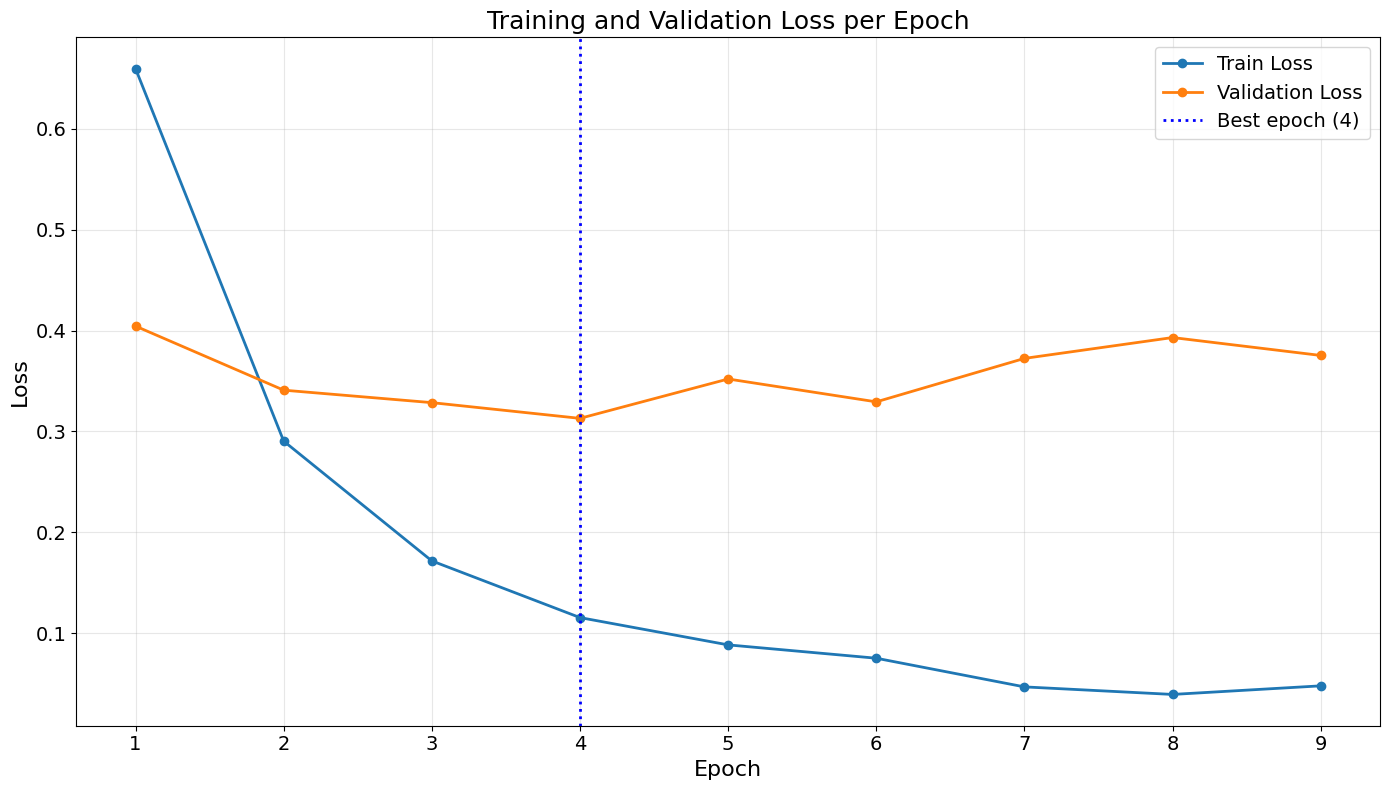

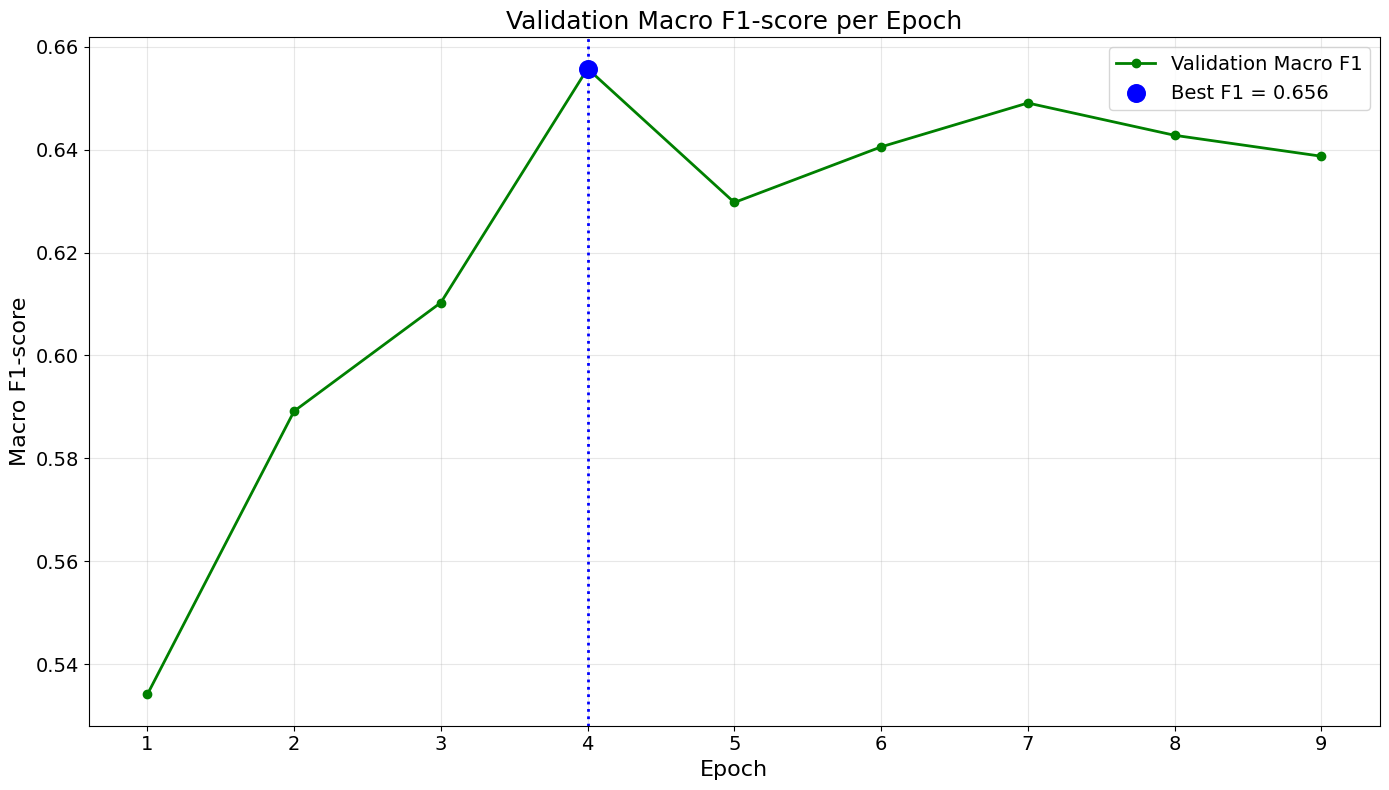

In [25]:
# @title
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

best_epoch = int(np.argmax(val_macro_f1_scores)) + 1
best_f1 = val_macro_f1_scores[best_epoch - 1]

# ================= LOSS =================
plt.figure(figsize=(14, 8))

plt.plot(epochs, train_losses, label="Train Loss", marker="o", linewidth=2)
plt.plot(epochs, val_losses,   label="Validation Loss", marker="o", linewidth=2)

plt.axvline(
    x=best_epoch,
    color="blue",
    linestyle=":",
    linewidth=2,
    label=f"Best epoch ({best_epoch})"
)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Training and Validation Loss per Epoch", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ================= MACRO F1 =================
plt.figure(figsize=(14, 8))

plt.plot(
    epochs,
    val_macro_f1_scores,
    label="Validation Macro F1",
    marker="o",
    linewidth=2,
    color="green"
)

plt.scatter(
    best_epoch,
    best_f1,
    color="blue",
    s=160,
    zorder=5,
    label=f"Best F1 = {best_f1:.3f}"
)

plt.axvline(
    x=best_epoch,
    color="blue",
    linestyle=":",
    linewidth=2
)

plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Macro F1-score", fontsize=16)
plt.title("Validation Macro F1-score per Epoch", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Confusion matrix"):
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

Confusion matrix: 100%|██████████| 185/185 [00:04<00:00, 37.46it/s]


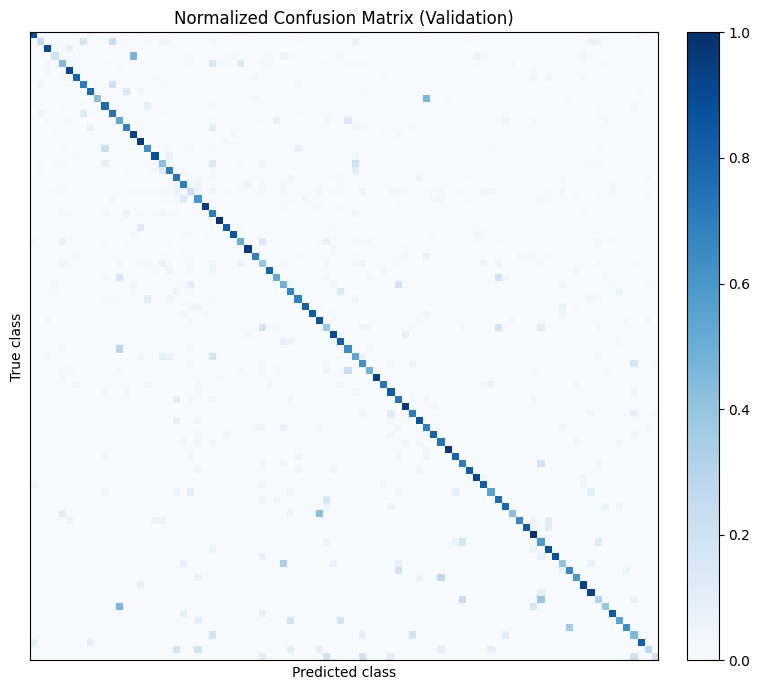

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# normalization by true classes
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
im = plt.imshow(cm_norm, cmap="Blues", interpolation="nearest")

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.title("Normalized Confusion Matrix (Validation)")
plt.xlabel("Predicted class")
plt.ylabel("True class")


plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("confusion_matrix_all_classes.png", dpi=300)
plt.show()

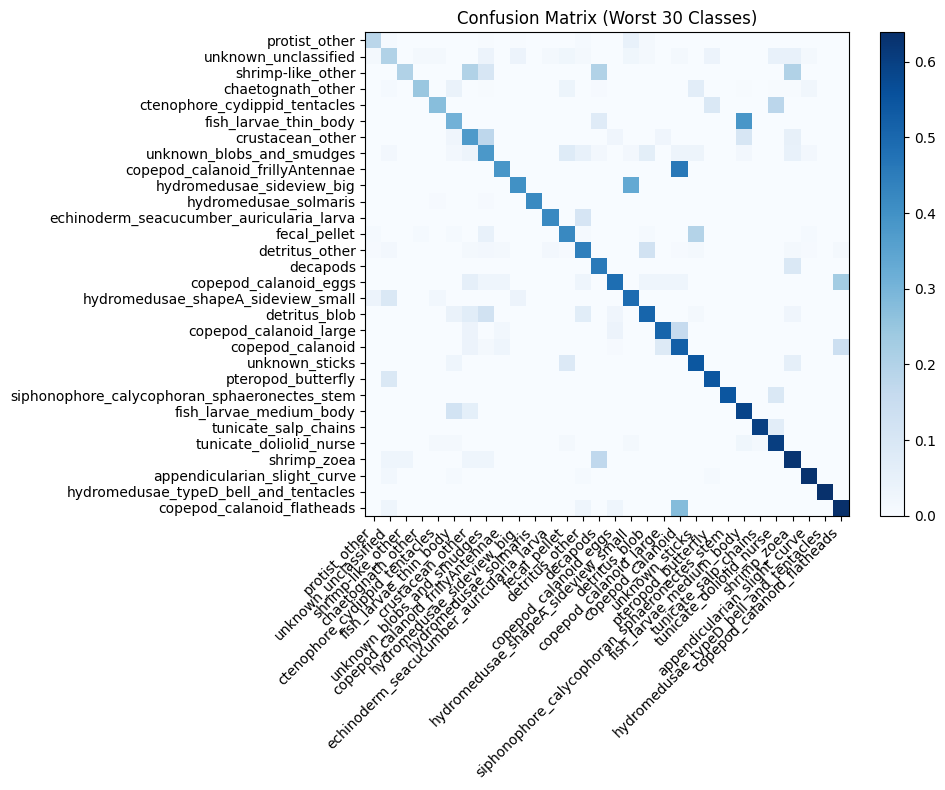

In [30]:
# accuracy per class
class_acc = np.diag(cm_norm)

# worst 20 classes
K = 30
worst_idx = np.argsort(class_acc)[:K]

cm_small = cm_norm[np.ix_(worst_idx, worst_idx)]
class_names_small = [classes_filtered[i] for i in worst_idx]

plt.figure(figsize=(10, 8))
im = plt.imshow(cm_small, cmap="Blues")
plt.colorbar(im)

plt.xticks(range(K), class_names_small, rotation=45, ha="right")
plt.yticks(range(K), class_names_small)

plt.title("Confusion Matrix (Worst 30 Classes)")
plt.tight_layout()
plt.savefig("confusion_matrix_top30.png", dpi=300)
plt.show()